# LNovelD

In [17]:
from model.modules.lnoveld import LNovelD

m = LNovelD(2, 2, 5)

In [18]:
m

LNovelD(
  (obs_noveld): NovelD(
    (target): MLPNetwork(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
        )
        (3): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
        )
        (4): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
        )
        (5): Linear(in_features=64, out_features=5, bias=True)
      )
    )
    (predictor): MLPNetwork(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
        )
        (3): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
        )
    

In [5]:
obs = torch.Tensor([[10.0, 10.0]])
m(obs, None)


target tensor([[-1.8384,  0.9695, -3.8054, -2.1500,  3.6722]])
pred tensor([[ 2.2023, -4.3319, -0.7381, -3.4516,  0.7183]],
       grad_fn=<AddmmBackward0>)
nov tensor([8.0162])
last nov tensor([0.8016])
comp tensor([-3.2065])
7.615405559539795


7.615405559539795

In [6]:
m.obs_noveld.episode_states_count

{(1.0, 1.0): 1, (10.0, 10.0): 1}

# Encoder

In [1]:
import torch
from model.modules.lm import GRUEncoder, OneHotEncoder

gru = GRUEncoder(
    10, 
    OneHotEncoder(['South','Not','Located','West','Object','Landmark','North','Center','East']))

opt = torch.optim.Adam(gru.gru.parameters(), lr=0.1)

sentences = [
    ["Located", "South"], 
    ["Located", "Center", "Object", "East"], 
    ["Located", "South"], 
    ["Located", "East", "Object", "South", "East"], 
    ["Located", "South", "West"]
]
sentences = [["<SOS>"] + s + ["<EOS>"] for s in sentences]

encs = gru(sentences)
gru(sentences)


tensor([[[ 0.0602, -0.1766, -0.0372,  0.1486,  0.3524,  0.0492, -0.0064,
           0.1933, -0.3469, -0.0596],
         [ 0.1362, -0.3001,  0.0173,  0.2752,  0.3259, -0.0171,  0.0233,
           0.0974, -0.2904, -0.0622],
         [ 0.0602, -0.1766, -0.0372,  0.1486,  0.3524,  0.0492, -0.0064,
           0.1933, -0.3469, -0.0596],
         [ 0.1281, -0.2525,  0.0050,  0.2414,  0.3356,  0.0387,  0.0285,
           0.1468, -0.3164, -0.0694],
         [ 0.1491, -0.2382,  0.0952,  0.1408,  0.3274,  0.1251, -0.0039,
           0.1219, -0.3603,  0.0718]]], grad_fn=<CopySlices>)

In [11]:
opt.zero_grad()
encs.mean().backward()
opt.step()

In [12]:
gru(sentences)

tensor([[[-0.4974, -0.3791, -0.1940, -0.3039, -0.1669, -0.2489, -0.5031,
          -0.1984, -0.5563, -0.0602],
         [-0.4415, -0.3436, -0.3280, -0.3862, -0.2037, -0.2943, -0.6240,
          -0.2357, -0.5833,  0.0067],
         [-0.4974, -0.3791, -0.1940, -0.3039, -0.1669, -0.2489, -0.5031,
          -0.1984, -0.5563, -0.0602],
         [-0.4591, -0.3452, -0.3098, -0.3782, -0.2319, -0.2676, -0.6360,
          -0.1869, -0.5940,  0.0045],
         [-0.5177, -0.3911, -0.2654, -0.3371, -0.1657, -0.3111, -0.5693,
          -0.2637, -0.5415, -0.0435]]], grad_fn=<CopySlices>)

# Decoder

In [1]:
import torch
from model.modules.lm import GRUDecoder, OneHotEncoder

word_encoder = OneHotEncoder(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'])
dec = GRUDecoder(10, word_encoder)

last_hidden = torch.ones((1, 1, 10))
last_word = torch.Tensor(word_encoder.SOS_ENC).unsqueeze(0).unsqueeze(0)

dec.forward_step(last_word, last_hidden)

(tensor([[[-2.3735, -2.4502, -2.6180, -2.0134, -2.3471, -2.8143, -2.6677,
           -1.8240, -2.4765, -2.5626, -2.7094]]], grad_fn=<LogSoftmaxBackward0>),
 tensor([[[ 0.6252,  0.7289,  0.8356,  0.5018,  0.7564,  0.8033,  0.7864,
            0.7227, -0.0403,  0.5622]]], grad_fn=<StackBackward0>))

In [2]:
context = torch.ones(2, 10)
targets = [
    torch.Tensor([
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
    torch.Tensor([
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
]

dec(context, targets)

Batch # 0
Token # 0
torch.Size([1, 1, 11])
tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
torch.Size([1, 1, 10])
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])
Token # 1
torch.Size([1, 1, 11])
tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]])
torch.Size([1, 1, 10])
tensor([[[ 0.6252,  0.7289,  0.8356,  0.5018,  0.7564,  0.8033,  0.7864,
           0.7227, -0.0403,  0.5622]]], grad_fn=<StackBackward0>)
Token # 2
torch.Size([1, 1, 11])
tensor([[[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])
torch.Size([1, 1, 10])
tensor([[[ 0.4122,  0.6449,  0.6308,  0.2169,  0.6463,  0.6911,  0.6096,
           0.3685, -0.2815,  0.2256]]], grad_fn=<StackBackward0>)
Token # 3
torch.Size([1, 1, 11])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]])
torch.Size([1, 1, 10])
tensor([[[ 0.1948,  0.4077,  0.4849,  0.1084,  0.5570,  0.3894,  0.4387,
           0.1903, -0.1325, -0.0323]]], grad_fn=<StackBackward0>)
Batch # 1
Token # 0
torch.Size([1, 1, 11])
tensor([[[1., 0., 0., 0.,

([tensor([[[[-2.3735, -2.4502, -2.6180, -2.0134, -2.3471, -2.8143, -2.6677,
             -1.8240, -2.4765, -2.5626, -2.7094]]],
  
  
          [[[-2.3814, -2.4873, -2.5747, -2.1063, -2.3153, -2.6529, -2.6838,
             -1.9245, -2.4462, -2.4562, -2.6485]]],
  
  
          [[[-2.4006, -2.5280, -2.5888, -2.1507, -2.3011, -2.6244, -2.6682,
             -2.0683, -2.2993, -2.4048, -2.5383]]],
  
  
          [[[-2.4772, -2.5148, -2.5760, -2.1886, -2.3192, -2.5286, -2.5830,
             -2.1398, -2.2926, -2.3642, -2.5180]]]], grad_fn=<StackBackward0>),
  tensor([[[[-2.3735, -2.4502, -2.6180, -2.0134, -2.3471, -2.8143, -2.6677,
             -1.8240, -2.4765, -2.5626, -2.7094]]],
  
  
          [[[-2.3814, -2.4873, -2.5747, -2.1063, -2.3153, -2.6529, -2.6838,
             -1.9245, -2.4462, -2.4562, -2.6485]]],
  
  
          [[[-2.4689, -2.4843, -2.5507, -2.1595, -2.3206, -2.5464, -2.5999,
             -2.0445, -2.3717, -2.4071, -2.5927]]]], grad_fn=<StackBackward0>)],
 [[], []])

# Train Encoder-Decoder

Load sentences

In [1]:
import json

def load_sentences(data_path):
    with open(data_path, "r") as f:
        data = json.load(f)
    sentences = []
    for step, s_data in data.items():
        if not step.startswith("Step"):
            continue
        sentences.append(s_data["Agent_0"]["Sentence"][1:-1])
        sentences.append(s_data["Agent_1"]["Sentence"][1:-1])
    return sentences
sentences = load_sentences("test_data/Sentences_Generated_P1.json")

Initialise Encoder and Decoder

In [2]:
import torch
from model.modules.lm import GRUEncoder, GRUDecoder, OneHotEncoder

word_encoder = OneHotEncoder(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'])

enc = GRUEncoder(32, word_encoder)
dec = GRUDecoder(32, word_encoder)

Initialise Loss and Optimizer

In [3]:
from torch import nn, optim

criterion = nn.NLLLoss()
optim = optim.SGD(list(enc.parameters()) + list(dec.parameters()), lr=0.001)

Train

In [6]:
import time
import random
from tqdm import tqdm 

def train(sentences, enc, dec, word_encoder, criterion, optim, n_iters=20000, batch_size=64):
    start = time.time()
    
    plot_losses = []
    
    for s_i in tqdm(range(n_iters)):
        optim.zero_grad()
        
        loss = 0
        
        # Sample batch
        batch = random.sample(sentences, batch_size)
        
        # Encoder forward pass
        enc_hidden_state = enc(batch)
        
        # Decoder forward pass
        enc_hidden_state.squeeze(0)
        encoded_targets = word_encoder.encode_batch(batch)
        decoder_outputs, _ = dec(enc_hidden_state.squeeze(0), encoded_targets)
        
        # Compute loss
        tot_len = 0
        for d_o, e_t in zip(decoder_outputs, encoded_targets):
            e_t = torch.argmax(e_t, dim=1)
            loss += criterion(d_o, e_t)
        
        # Backprop
        loss.backward()
        optim.step()
        
        plot_losses.append(loss.item())
    
    return plot_losses
            
plot_loss = train(sentences, enc, dec, word_encoder, criterion, optim)

100%|██████████████████████████████████████████████████████████████| 20000/20000 [45:00<00:00,  7.41it/s]


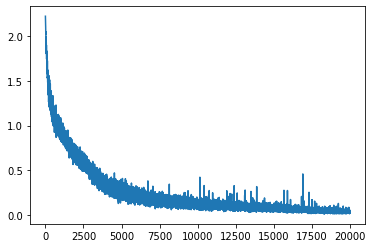

In [12]:
import matplotlib.pyplot as plt

plt.plot(plot_loss)

In [11]:
plot_loss = [l / 64 for l in plot_loss]

Evaluate

In [13]:
s = sentences[8]
s_enc = enc([s])
_, s_pred = dec(s_enc)
s_pred

[[array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])]]

In [10]:
s

['Located', 'East', 'Landmark', 'West']

In [14]:
word_encoder.decode_batch(s_pred)

[['Located', 'East', 'Landmark', 'West']]

# Observation captioning

Let's try to learn to generate the sentence corresponding to a given observation.

The Observation Encoder will be trained to encode the observation, and the Decoder will have to predict the sentence description of the observation.

Load observation-sentence pairs.

In [1]:
import json

def load_pairs(data_path):
    with open(data_path, "r") as f:
        data = json.load(f)
    pairs = []
    for step, s_data in data.items():
        if not step.startswith("Step"):
            continue
        pairs.append({
            "observation": s_data["Agent_0"]["Observation"],
            "sentence": s_data["Agent_0"]["Sentence"][1:-1]
        })
        pairs.append({
            "observation": s_data["Agent_1"]["Observation"],
            "sentence": s_data["Agent_1"]["Sentence"][1:-1]
        })
    return pairs

data_pairs = load_pairs("test_data/Sentences_Generated_P1.json")
data_pairs[0]

{'observation': [0.3566717617981794,
  0.22018956073987805,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  -0.4988445287954038,
  -0.25249793046375035],
 'sentence': ['Located', 'East', 'Landmark', 'South', 'West']}

Split data

In [ ]:
train_data = data_pairs[:80000]
test_data = data_pairs[80000:]

Initialise the models

In [15]:
import torch
from model.modules.lm import GRUDecoder, OneHotEncoder
from model.modules.obs import ObservationEncoder

word_encoder = OneHotEncoder(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'])

dec = GRUDecoder(32, word_encoder)

obs_enc = ObservationEncoder(17, 32)

Initialise loss and optimizer

In [16]:
from torch import nn, optim

criterion = nn.NLLLoss()
optim = optim.SGD(list(dec.parameters()) + list(obs_enc.parameters()), lr=0.01)

Train

In [17]:
import time
import random
import numpy as np
from tqdm import tqdm 

def train(data, obs_enc, dec, word_encoder, criterion, optim, n_iters=10000, batch_size=64):
    start = time.time()
    
    plot_losses = []
    
    for s_i in tqdm(range(n_iters)):
        optim.zero_grad()
        
        loss = 0
        
        # Sample batch
        batch = random.sample(data, batch_size)
        obs_batch = []
        sent_batch = []
        for pair in batch:
            obs_batch.append(pair["observation"])
            sent_batch.append(pair["sentence"])
        
        # Encode observations
        obs_tensor = torch.Tensor(np.array(obs_batch))
        context_batch = obs_enc(obs_tensor)
        
        # Decoder forward pass
        encoded_targets = word_encoder.encode_batch(sent_batch)
        decoder_outputs, _ = dec(context_batch, encoded_targets)
        
        # Compute loss
        for d_o, e_t in zip(decoder_outputs, encoded_targets):
            e_t = torch.argmax(e_t, dim=1)
            loss += criterion(d_o, e_t)
        
        # Backprop
        loss.backward()
        optim.step()
        
        plot_losses.append(loss.item() / batch_size)
    
    return plot_losses
            
plot_loss = train(data_pairs, obs_enc, dec, word_encoder, criterion, optim)

100%|██████████████████████████████████████████████████████████████| 10000/10000 [22:32<00:00,  7.39it/s]


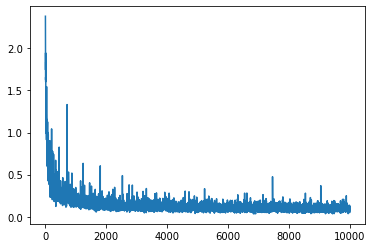

In [18]:
import matplotlib.pyplot as plt

plt.plot(plot_loss)

# Learning to encode language with Contrastive Learning

Contrastive learning of observation encodings. The goal is to have two encoders, one for the observation and one for the language description, both encoding to the same context embedding. 

Load observation-sentence pairs:

In [36]:
import json

def load_pairs(data_path):
    with open(data_path, "r") as f:
        data = json.load(f)
    pairs = []
    for step, s_data in data.items():
        if not step.startswith("Step"):
            continue
        pairs.append({
            "observation": s_data["Agent_0"]["Observation"],
            "sentence": s_data["Agent_0"]["Sentence"][1:-1]
        })
        pairs.append({
            "observation": s_data["Agent_1"]["Observation"],
            "sentence": s_data["Agent_1"]["Sentence"][1:-1]
        })
    return pairs

data_pairs = load_pairs("test_data/Sentences_Generated_P1.json")
data_pairs[0]

{'observation': [0.3566717617981794,
  0.22018956073987805,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  -0.4988445287954038,
  -0.25249793046375035],
 'sentence': ['Located', 'East', 'Landmark', 'South', 'West']}

Split data

In [43]:
train_data = data_pairs[:80000]
test_data = data_pairs[80000:]

In [45]:
len(test_data)

20000

Initialise the models

In [65]:
import torch
from model.modules.lm import GRUEncoder, OneHotEncoder
from model.modules.obs import ObservationEncoder

word_encoder = OneHotEncoder(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'])

lang_enc = GRUEncoder(32, word_encoder)

obs_enc = ObservationEncoder(17, 32)

Initialise loss and optimizer

In [71]:
from torch import nn, optim

criterion = nn.CrossEntropyLoss()
opt = optim.SGD(list(dec.parameters()) + list(obs_enc.parameters()), lr=0.1)

Train

In [67]:
import time
import random
import numpy as np
from tqdm import tqdm 

def sample_batch(data, batch_size):
    batch = random.sample(data, batch_size)
    obs_batch = []
    sent_batch = []
    for pair in batch:
        obs_batch.append(pair["observation"])
        sent_batch.append(pair["sentence"])
    return obs_batch, sent_batch

def get_clip_loss(obs_batch, sent_batch, obs_enc, lang_enc, temp, cross_ent_loss):
    # Encode observations
    obs_tensor = torch.Tensor(np.array(obs_batch))
    context_batch = obs_enc(obs_tensor)

    # Encode sentence
    lang_context_batch = lang_enc(sent_batch)
    lang_context_batch = lang_context_batch.squeeze()

    # Compute similarity
    context_batch = context_batch / context_batch.norm(dim=1, keepdim=True)
    lang_context_batch = lang_context_batch / lang_context_batch.norm(dim=1, keepdim=True)
    sim = context_batch @ lang_context_batch.t() * temp

    # Compute loss
    labels = torch.arange(len(obs_batch))
    loss_o = cross_ent_loss(sim, labels)
    loss_l = cross_ent_loss(sim.t(), labels)
    loss = (loss_o + loss_l) / 2
    
    return loss

def train(data, obs_enc, lang_enc, word_encoder, cross_ent_loss, opt, 
          n_iters=80000, batch_size=128, temp=0.07, eval_data=None, eval_evry=1000):
    start = time.time()
    
    train_losses = []
    eval_losses = []
    
    for s_i in tqdm(range(n_iters)):
        optim.zero_grad()
        
        # Sample batch
        obs_batch, sent_batch = sample_batch(data, batch_size)
        
        # Compute loss
        loss = get_clip_loss(obs_batch, sent_batch, obs_enc, lang_enc, temp, cross_ent_loss)
        
        # Backprop
        loss.backward()
        opt.step()
        
        train_losses.append(loss.item())
        
        if eval_data is not None and s_i % eval_evry == 0:
            with torch.no_grad():
                # Sample batch
                obs_batch, sent_batch = sample_batch(eval_data, batch_size)
                
                # Get loss
                loss = get_clip_loss(obs_batch, sent_batch, obs_enc, lang_enc, temp, cross_ent_loss)
                eval_losses.append(loss)
    
    return train_losses, eval_losses
            
train_loss, eval_loss = train(train_data, obs_enc, lang_enc, word_encoder, criterion, opt, eval_data=test_data)

100%|████████████████████████████████████████████████████████| 80000/80000 [1:28:28<00:00, 15.07it/s]


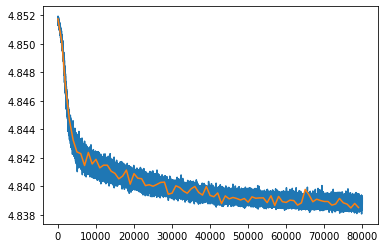

In [69]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(np.arange(80) * 1000, eval_loss)

Smaller context vector, higher learning rate

100%|████████████████████████████████████████████████████████████| 80000/80000 [1:36:24<00:00, 13.83it/s]


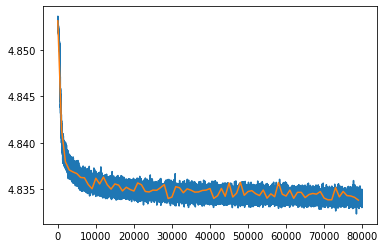

In [73]:
lang_enc = GRUEncoder(16, word_encoder)
obs_enc = ObservationEncoder(17, 16)

criterion = nn.CrossEntropyLoss()
opt = optim.SGD(list(dec.parameters()) + list(obs_enc.parameters()), lr=0.2)

train_loss, eval_loss = train(train_data, obs_enc, lang_enc, word_encoder, criterion, opt, eval_data=test_data)

plt.plot(train_loss)
plt.plot(np.arange(80) * 1000, eval_loss)

Higher learning rate

100%|████████████████████████████████████████████████████████████| 80000/80000 [1:54:55<00:00, 11.60it/s]


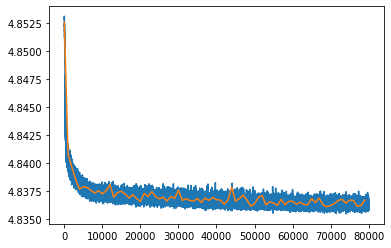

In [74]:
lang_enc = GRUEncoder(16, word_encoder)
obs_enc = ObservationEncoder(17, 16)

criterion = nn.CrossEntropyLoss()
opt = optim.SGD(list(dec.parameters()) + list(obs_enc.parameters()), lr=0.5)

train_loss, eval_loss = train(train_data, obs_enc, lang_enc, word_encoder, criterion, opt, eval_data=test_data)

plt.plot(train_loss)
plt.plot(np.arange(80) * 1000, eval_loss)